In [1]:
import sys
sys.path.append("../")
sys.path.append("../../../assets/diffusion")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd
import pickle

from experiments import RandomWalkDiffusionExperiment
from models import RandomWalkDiffusion
from configuration import default_num_steps

/home/divergence/anaconda3/envs/bfPower/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
SIMULATE_DATA = False
TRAIN_NETWORKS = False
FIT_MODEL = True

NUM_SIM = 200
NUM_STEPS = 400
NUM_SAMPLES = 2000

PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v$', r'$a$', r'$\tau$']

FONT_SIZE_1 = 20
FONT_SIZE_2 = 18
FONT_SIZE_3 = 16

In [3]:
random_walk_ddm = RandomWalkDiffusion(**default_num_steps)
experiment = RandomWalkDiffusionExperiment(random_walk_ddm)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 400, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 400)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 400, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/simulation_study/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/simulation_study/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Simulation

In [5]:
if SIMULATE_DATA:
    from models import StaticDiffusion, StationaryDiffusion, RegimeSwitchingDiffusion
    static_ddm = StaticDiffusion()
    stationary_ddm = StationaryDiffusion()
    regime_switching_ddm = RegimeSwitchingDiffusion()
    static_ddm_sim = static_ddm.generate(NUM_SIM)
    stationary_ddm_sim = stationary_ddm.generate(NUM_SIM)
    random_walk_ddm_sim = random_walk_ddm.generate(NUM_SIM)
    regime_switching_ddm_sim = regime_switching_ddm.generate(NUM_SIM)
    with open('../data/static_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(static_ddm_sim, f)
    with open('../data/stationary_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(stationary_ddm_sim, f)
    with open('../data/random_walk_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(random_walk_ddm_sim, f)
    with open('../data/regime_switching_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(regime_switching_ddm_sim, f)
else:
    with open('../data/static_ddm_sim_200.pkl', 'rb') as f:
        static_ddm_sim = pickle.load(f)
    with open('../data/stationary_ddm_sim_200.pkl', 'rb') as f:
        stationary_ddm_sim = pickle.load(f)
    with open('../data/random_walk_ddm_sim_200.pkl', 'rb') as f:
        random_walk_ddm_sim = pickle.load(f)
    with open('../data/regime_switching_ddm_sim_200.pkl', 'rb') as f:
        regime_switching_ddm_sim = pickle.load(f)

## Training

In [6]:
if TRAIN_NETWORKS:
    history = experiment.run(
        epochs=75, 
        iterations_per_epoch=1000,
        batch_size=16
    )
else:
    history = experiment.trainer.loss_history.get_plottable()

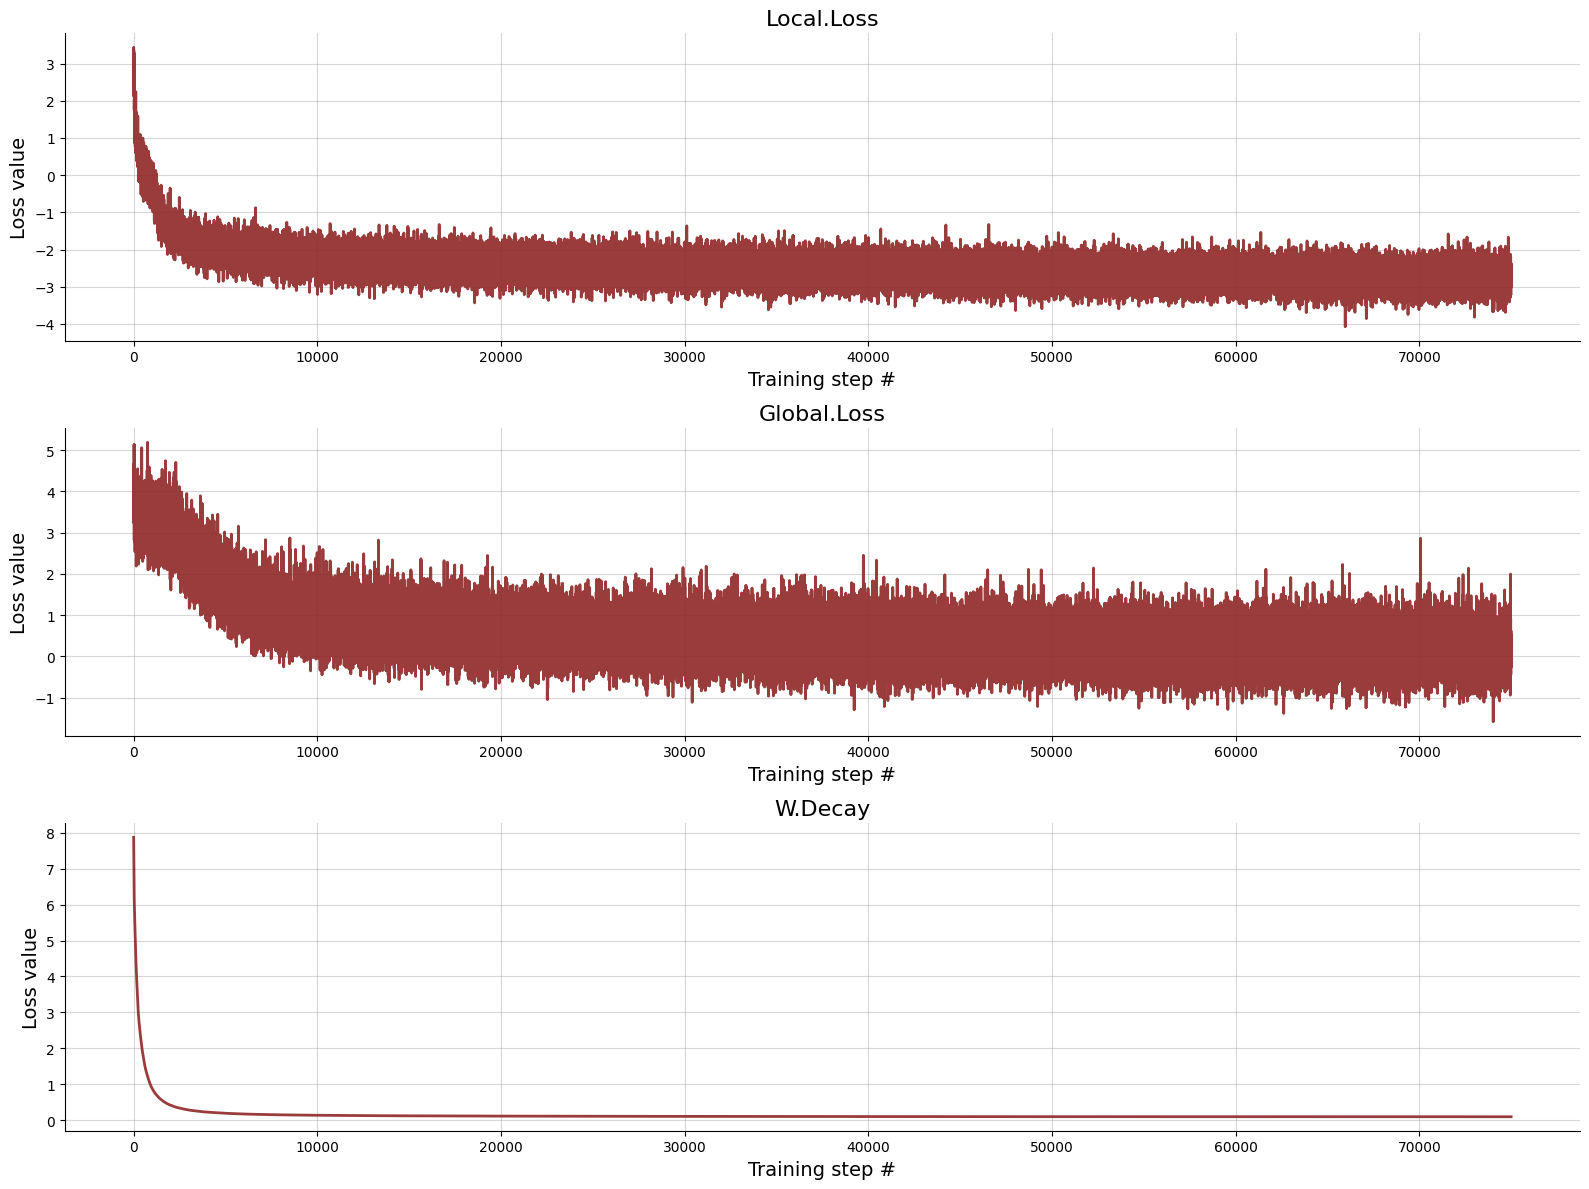

In [7]:
f = beef.diagnostics.plot_losses(history)

## Evaluation

In [8]:
with tf.device('/cpu:0'):
    if FIT_MODEL:
        local_post_static = np.zeros((NUM_SIM, NUM_STEPS, NUM_SAMPLES, 3))
        global_post_static = np.zeros((NUM_SIM, NUM_SAMPLES, 3))
        local_post_stationary = np.zeros((NUM_SIM, NUM_STEPS, NUM_SAMPLES, 3))
        global_post_stationary = np.zeros((NUM_SIM, NUM_SAMPLES, 3))
        local_post_random_walk = np.zeros((NUM_SIM, NUM_STEPS, NUM_SAMPLES, 3))
        global_post_random_walk = np.zeros((NUM_SIM, NUM_SAMPLES, 3))
        local_post_regime_switching = np.zeros((NUM_SIM, NUM_STEPS, NUM_SAMPLES, 3))
        global_post_regime_switching = np.zeros((NUM_SIM, NUM_SAMPLES, 3))


        for sim in range(NUM_SIM):
            # static ddm
            post_samples = experiment.amortizer.sample(
                {'summary_conditions': static_ddm_sim['sim_data'][sim:sim+1, :, None]},
                NUM_SAMPLES
            )
            local_post_static[sim] = post_samples['local_samples']
            global_post_static[sim] = post_samples['global_samples']
            # stationary ddm
            post_samples = experiment.amortizer.sample(
                {'summary_conditions': stationary_ddm_sim['sim_data'][sim:sim+1, :, None]},
                NUM_SAMPLES
            )
            local_post_stationary[sim] = post_samples['local_samples']
            global_post_stationary[sim] = post_samples['global_samples']
            # random walk ddm
            post_samples = experiment.amortizer.sample(
                {'summary_conditions': random_walk_ddm_sim['sim_data'][sim:sim+1, :, None]},
                NUM_SAMPLES
            )
            local_post_random_walk[sim] = post_samples['local_samples']
            global_post_random_walk[sim] = post_samples['global_samples']
            # regime switching ddm
            post_samples = experiment.amortizer.sample(
                {'summary_conditions': regime_switching_ddm_sim['sim_data'][sim:sim+1, :, None]},
                NUM_SAMPLES
            )
            local_post_regime_switching[sim] = post_samples['local_samples']
            global_post_regime_switching[sim] = post_samples['global_samples']
            
        np.save('../data/local_post_static.npy', local_post_static)
        np.save('../data/global_post_static.npy', global_post_static)
        np.save('../data/local_post_stationary.npy', local_post_stationary)
        np.save('../data/global_post_stationary.npy', global_post_stationary)
        np.save('../data/local_post_random_walk.npy', local_post_random_walk)
        np.save('../data/global_post_random_walk.npy', global_post_random_walk)
        np.save('../data/local_post_regime_switching.npy', local_post_regime_switching)
        np.save('../data/global_post_regime_switching.npy', global_post_regime_switching)

    else:
        local_post_static = np.load('../data/local_post_static.npy')
        global_post_static = np.load('../data/global_post_static.npy')
        local_post_stationary = np.load('../data/local_post_stationary.npy')
        global_post_stationary = np.load('../data/global_post_stationary.npy')
        local_post_random_walk = np.load('../data/local_post_random_walk.npy')
        global_post_random_walk = np.load('../data/global_post_random_walk.npy')
        local_post_regime_switching = np.load('../data/local_post_regime_switching.npy')
        global_post_regime_switching = np.load('../data/global_post_regime_switching.npy')
        

In [9]:
# unscale posterior samples
local_post_static = local_post_static * random_walk_ddm.local_prior_stds + random_walk_ddm.local_prior_means
local_post_stationary = local_post_stationary * random_walk_ddm.local_prior_stds + random_walk_ddm.local_prior_means
local_post_random_walk = local_post_random_walk * random_walk_ddm.local_prior_stds + random_walk_ddm.local_prior_means
local_post_regime_switching = local_post_regime_switching * random_walk_ddm.local_prior_stds + random_walk_ddm.local_prior_means

In [10]:
# calculate posterior means
local_post_static_means = local_post_static.mean(axis=2)
local_post_stationary_means = local_post_stationary.mean(axis=2)
local_post_random_walk_means = local_post_random_walk.mean(axis=2)
local_post_regime_switching_means = local_post_regime_switching.mean(axis=2)

In [11]:
# calculate absolute error between true and estimated parameter
abs_error_static = np.empty((NUM_SIM, NUM_STEPS, 3))
abs_error_stationary = np.empty((NUM_SIM, NUM_STEPS, 3))
for i in range(NUM_SIM):
    abs_error_static[i] = np.abs(local_post_static_means[i] - static_ddm_sim['prior_draws'][i])
    abs_error_stationary[i] = np.abs(local_post_stationary_means[i] - stationary_ddm_sim['prior_draws'][i, :3])
abs_error_random_walk = np.abs(local_post_random_walk_means - random_walk_ddm_sim['local_prior_draws'])
abs_error_regime_switching = np.abs(local_post_regime_switching_means - regime_switching_ddm_sim['prior_draws'])

In [12]:
# aggregate absolute error over simulations
abs_error_static_mean = abs_error_static.mean(axis=0)
abs_error_static_std = abs_error_static.std(axis=0)
abs_error_stationary_mean = abs_error_stationary.mean(axis=0)
abs_error_stationary_std = abs_error_stationary.std(axis=0)
abs_error_random_walk_mean = abs_error_random_walk.mean(axis=0)
abs_error_random_walk_std = abs_error_random_walk.std(axis=0)
abs_error_regime_switching_mean = abs_error_regime_switching.mean(axis=0)
abs_error_regime_switching_std = abs_error_regime_switching.std(axis=0)

In [13]:
mean_summaries = np.array([abs_error_static_mean, abs_error_stationary_mean,
                abs_error_random_walk_mean, abs_error_regime_switching_mean])
std_summaries = np.array([abs_error_static_std, abs_error_stationary_std,
                abs_error_random_walk_std, abs_error_regime_switching_std])

In [14]:
subfigure_titles = ["Static DDM", "Stationary Variablity DDM",
                    "Non-Stationary Variability DDM", "Regime Switching DDM"]

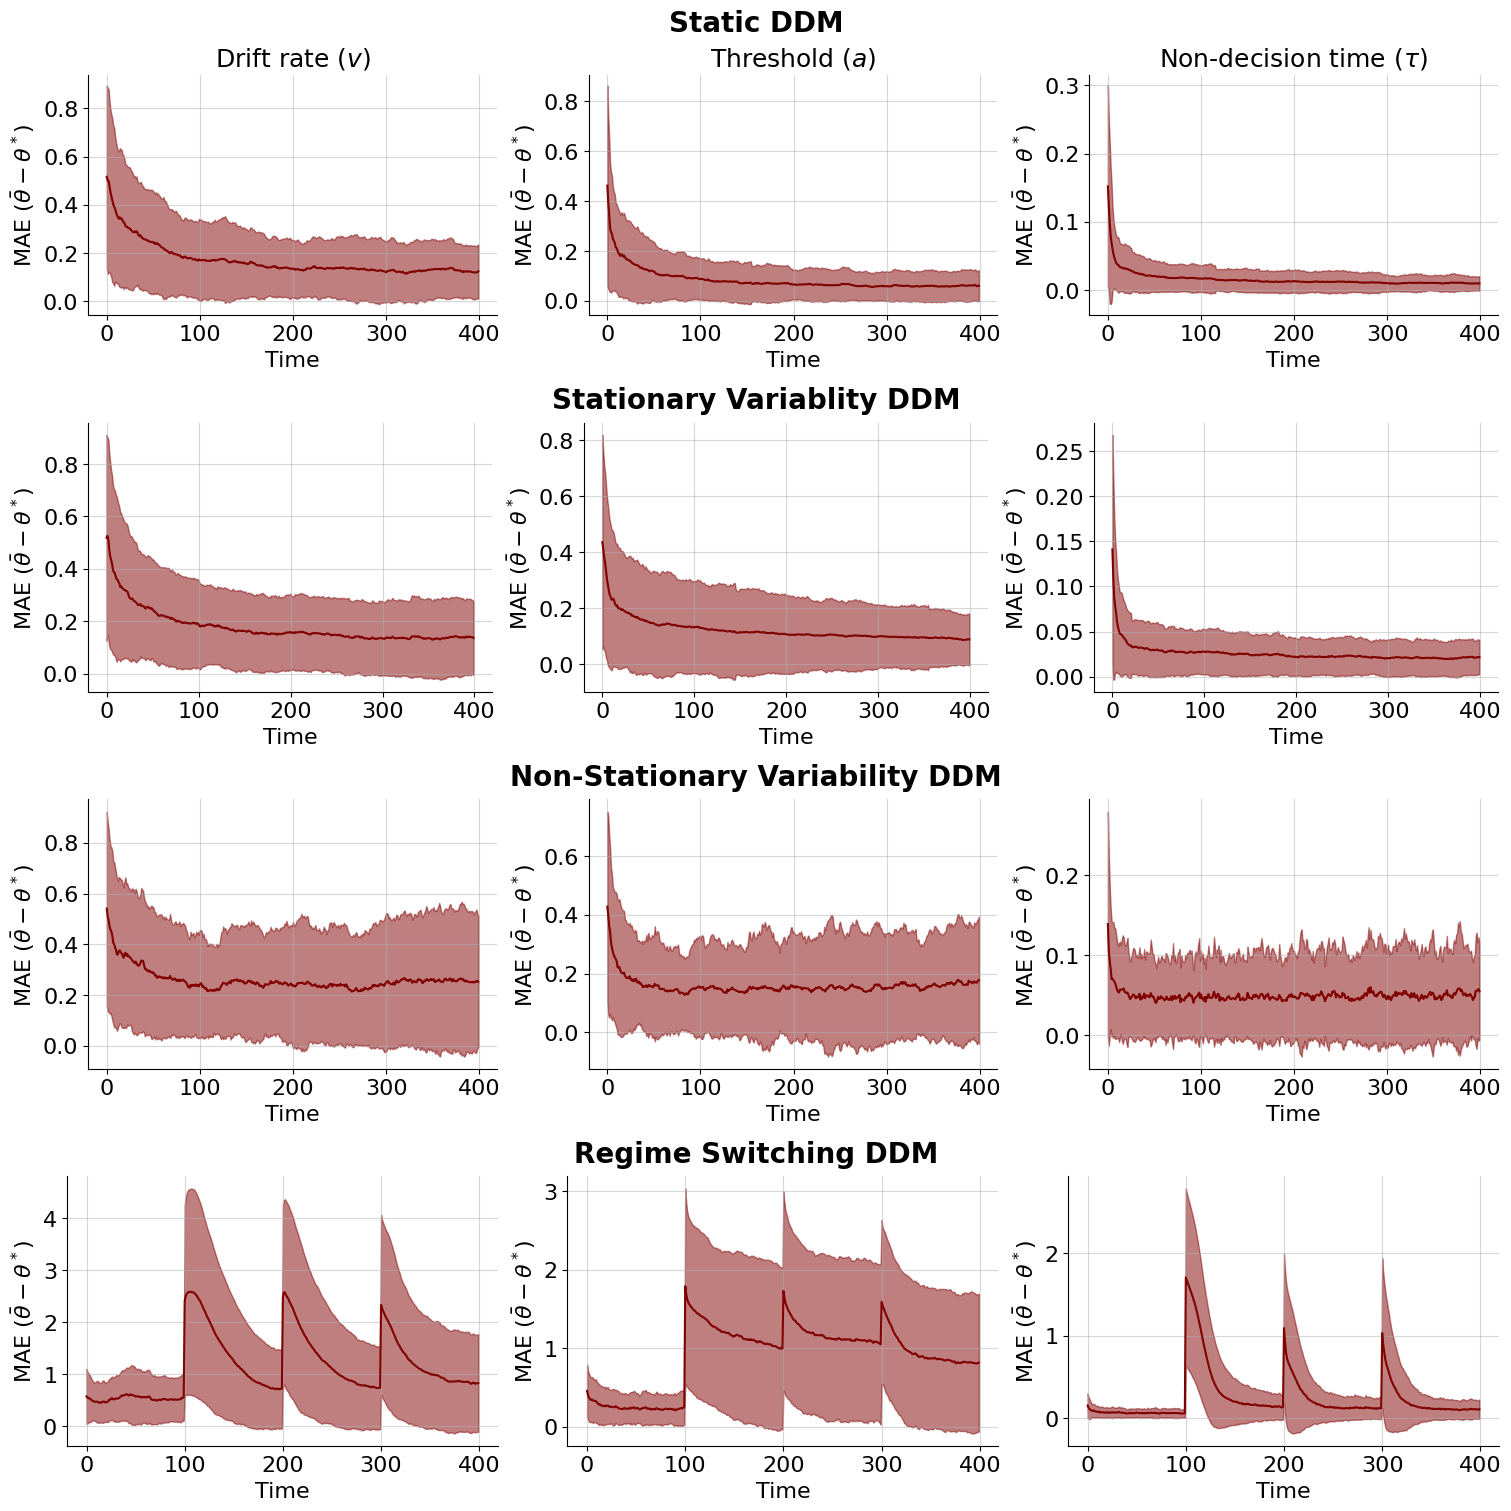

In [15]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15))

# create 4x1 subfigs
subfigs = fig.subfigures(nrows=4, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=FONT_SIZE_1, fontweight='semibold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        ax.plot(
            np.arange(NUM_STEPS), mean_summaries[row, :, col],
            color = "maroon"
        )
        
        ax.fill_between(
            np.arange(NUM_STEPS),
            mean_summaries[row, :, col] - std_summaries[row, :, col],
            mean_summaries[row, :, col] + std_summaries[row, :, col],
            alpha = 0.5,
            color = "maroon"
        )
        ax.grid(alpha=0.5)
        
        if row == 0:
            ax.set_title(PARAM_LABELS[col] + ' ({})'.format(PARAM_NAMES[col]), fontsize=FONT_SIZE_2)
            
        ax.set_xlabel('Time', fontsize=FONT_SIZE_3)
        ax.set_ylabel(r'MAE $(\bar{\theta} - \theta^*)$', fontsize=FONT_SIZE_3)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        
    
        
sns.despine()
f.tight_layout()

plt.savefig('../plots/simulation_study_result.png', dpi=300)